In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import re

---

In [4]:
zone = 0
zone_data = pd.read_csv("smaller_zone/zone_0/c3_ABLE_1950_08.csv", usecols=["coord_index", "time_step", "latitude_rank", "longitude_rank"])
zone_data = zone_data[zone_data["time_step"]==min(zone_data["time_step"])][["latitude_rank", "longitude_rank"]]

zone_min_lat = min(zone_data["latitude_rank"])
zone_min_lon = min(zone_data["longitude_rank"])
zone_data["latitude_rank"] = zone_data["latitude_rank"] - zone_min_lat + 1
zone_data["longitude_rank"] = zone_data["longitude_rank"] - zone_min_lon + 1
num_lat = max(zone_data["latitude_rank"])
zone_data = zone_data.sort_values(by=["longitude_rank", "latitude_rank"])
zone_data["coord_index"] = (zone_data["longitude_rank"]-1)*num_lat + zone_data["latitude_rank"]
zone_data = zone_data.sort_values(by="coord_index")
zone_data = zone_data.set_index("coord_index")

In [5]:
node_df = pd.read_csv(f"smaller_nodes/nodes_zone_{zone}.csv", usecols=["node1", "node2"])
node1 = node_df["node1"].to_numpy()
node2 = node_df["node2"].to_numpy()
N_nodes = node2.max()
node1_diag = np.concatenate([node1, np.arange(1, N_nodes + 1)])
node2_diag = np.concatenate([node2, np.arange(1, N_nodes + 1)])
N_edges = len(node1)
N_edges_diag = len(node1_diag)

In [6]:
# Edges for each node
node_edges = []
for n in range(1, N_nodes+1):
    n_edges = []
    for e in range(len(node1)):
        if ((n==node1[e]) | (n==node2[e])):
            n_edges.append(e+1)
    node_edges.append(n_edges)

node_edges_diag = []
for n in range(1, N_nodes+1):
    n_edges_diag = []
    for e in range(len(node1_diag)):
        if ((n==node1_diag[e]) | (n==node2_diag[e])):
            n_edges_diag.append(e+1)
    node_edges_diag.append(n_edges_diag)

In [7]:
node_north_edges = []
node_east_edges = []
node_south_edges = []
node_west_edges = []
node_vert_edges = []

for n in range(1, N_nodes+1):
    node_latitude = zone_data.loc[n, "latitude_rank"]
    node_longitude = zone_data.loc[n, "longitude_rank"]
    n_north_edges = []
    n_east_edges = []
    n_south_edges = []
    n_west_edges = []
    n_vert_edges = []

    n_edges = node_edges_diag[n-1]
    for e in n_edges:
        # Selecting other node in edge
        other_node = node1_diag[e-1]
        if other_node==n:
            other_node = node2_diag[e-1]
        other_node_latitude = zone_data.loc[other_node, "latitude_rank"]
        other_node_longitude = zone_data.loc[other_node, "longitude_rank"]
        coord_difference = (node_latitude - other_node_latitude, node_longitude - other_node_longitude)
        if coord_difference == (1, 0):
            n_south_edges.append(e)
        elif coord_difference == (-1, 0):
            n_north_edges.append(e)
        elif coord_difference == (0, 1):
            n_west_edges.append(e)
        elif coord_difference == (0, -1):
            n_east_edges.append(e)
        elif coord_difference == (0, 0):
            n_vert_edges.append(e)
        else:
            print("something wrong")
    node_north_edges.append(n_north_edges)
    node_east_edges.append(n_east_edges)
    node_south_edges.append(n_south_edges)
    node_west_edges.append(n_west_edges)
    node_vert_edges.append(n_vert_edges)

---

In [8]:
def rename_param(col, edge_map, edge_diag_map):
    match = re.match(r"(w1|w2|p)\[(\d+)\]", col)
    if match:
        base, idx = match.groups()
        idx = int(idx)
        if base in ("w1", "w2"):
            edge_key = edge_map.get(idx)
        elif base == "p":
            edge_key = edge_diag_map.get(idx)
        else:
            edge_key = None
        return f"{base}[{edge_key}]" if edge_key else col
    return col

def safe_mean(draws, columns):
    return np.mean(draws[columns].values, axis=1) if columns else np.full(draws.shape[0], np.nan)

def safe_abs_mean(draws, columns):
    return np.mean(np.abs(draws[columns].values), axis=1) if columns else np.full(draws.shape[0], np.nan)

def safe_sum(draws, columns):
    return np.sum(draws[columns].values, axis=1) if columns else np.full(draws.shape[0], np.nan)

In [9]:
def process_draws(draws):
    processed_draws = draws[["lp__", ".chain", ".iteration"]].copy()
    new_columns = {}
    for n in range(1, N_nodes + 1):
        n_edges = node_edges[n-1]
        n_edges_diag = node_edges_diag[n-1]
        n_north_edges = node_north_edges[n-1]
        n_east_edges = node_east_edges[n-1]
        n_south_edges = node_south_edges[n-1]
        n_west_edges = node_west_edges[n-1]
        n_vert_edges = node_vert_edges[n-1]

        total_w1 = [f"w1[{e}]" for e in n_edges if f"w1[{e}]" in draws.columns]
        total_w2 = [f"w2[{e}]" for e in n_edges if f"w2[{e}]" in draws.columns]
        total_p = [f"p[{e}]" for e in n_edges_diag if f"p[{e}]" in draws.columns]

        north_w1 = [f"w1[{e}]" for e in n_north_edges if f"w1[{e}]" in draws.columns]
        east_w1 = [f"w1[{e}]" for e in n_east_edges if f"w1[{e}]" in draws.columns]
        south_w1 = [f"w1[{e}]" for e in n_south_edges if f"w1[{e}]" in draws.columns]
        west_w1 = [f"w1[{e}]" for e in n_west_edges if f"w1[{e}]" in draws.columns]

        north_w2 = [f"w2[{e}]" for e in n_north_edges if f"w2[{e}]" in draws.columns]
        east_w2 = [f"w2[{e}]" for e in n_east_edges if f"w2[{e}]" in draws.columns]
        south_w2 = [f"w2[{e}]" for e in n_south_edges if f"w2[{e}]" in draws.columns]
        west_w2 = [f"w2[{e}]" for e in n_west_edges if f"w2[{e}]" in draws.columns]

        north_p = [f"p[{e}]" for e in n_north_edges if f"p[{e}]" in draws.columns]
        east_p = [f"p[{e}]" for e in n_east_edges if f"p[{e}]" in draws.columns]
        south_p = [f"p[{e}]" for e in n_south_edges if f"p[{e}]" in draws.columns]
        west_p = [f"p[{e}]" for e in n_west_edges if f"p[{e}]" in draws.columns]
        vert_p = [f"p[{e}]" for e in n_vert_edges if f"p[{e}]" in draws.columns]

        new_columns[f"tot_w1[{n}]"] = safe_mean(draws, total_w1)
        new_columns[f"tot_w2[{n}]"] = safe_mean(draws, total_w2)
        new_columns[f"tot_p[{n}]"] = safe_mean(draws, total_p)

        new_columns[f"tot_abs_w1[{n}]"] = safe_abs_mean(draws, total_w1)
        new_columns[f"tot_abs_w2[{n}]"] = safe_abs_mean(draws, total_w2)
        new_columns[f"tot_abs_p[{n}]"] = safe_abs_mean(draws, total_p)

        new_columns[f"north_w1[{n}]"] = safe_sum(draws, north_w1)
        new_columns[f"east_w1[{n}]"] = safe_sum(draws, east_w1)
        new_columns[f"south_w1[{n}]"] = safe_sum(draws, south_w1)
        new_columns[f"west_w1[{n}]"] = safe_sum(draws, west_w1)

        new_columns[f"north_w2[{n}]"] = safe_sum(draws, north_w2)
        new_columns[f"east_w2[{n}]"] = safe_sum(draws, east_w2)
        new_columns[f"south_w2[{n}]"] = safe_sum(draws, south_w2)
        new_columns[f"west_w2[{n}]"] = safe_sum(draws, west_w2)

        new_columns[f"north_p[{n}]"] = safe_sum(draws, north_p)
        new_columns[f"east_p[{n}]"] = safe_sum(draws, east_p)
        new_columns[f"south_p[{n}]"] = safe_sum(draws, south_p)
        new_columns[f"west_p[{n}]"] = safe_sum(draws, west_p)
        new_columns[f"vert_p[{n}]"] = safe_sum(draws, vert_p)

    processed_draws = pd.concat([processed_draws, pd.DataFrame(new_columns)], axis=1)
    return processed_draws

---

In [10]:
correlation_names = ["tot_w1", "tot_abs_w1", "north_w1", "east_w1", "south_w1", "west_w1",
                     "tot_w2", "tot_abs_w2", "north_w2", "east_w2", "south_w2", "west_w2",
                     "tot_p", "tot_abs_p", "north_p", "east_p", "south_p", "west_p", "vert_p"]

correlation_labels = {"tot_w1": r"location mean $\omega^1$",
                      "tot_abs_w1": r"location absolute mean $\omega^1$",
                      "north_w1": r"northward edge $\omega^1$",
                      "east_w1": r"eastward edge $\omega^1$",
                      "south_w1": r"southward edge $\omega^1$",
                      "west_w1": r"westward edge $\omega^1$",
                      "tot_w2": r"location mean $\omega^2$",
                      "tot_abs_w2": r"location absolute mean $\omega^2$",
                      "north_w2": r"northward edge $\omega^2$",
                      "east_w2": r"eastward edge $\omega^2$",
                      "south_w2": r"southward edge $\omega^2$",
                      "west_w2": r"westward edge $\omega^2$",
                      "tot_p": r"location mean $\rho$",
                      "tot_abs_p": r"location absolute mean $\rho$",
                      "north_p": r"northward edge $\rho$",
                      "east_p": r"eastward edge $\rho$",
                      "south_p": r"southward edge $\rho$",
                      "west_p": r"westward edge $\rho$",
                      "vert_p": r"vertical (between-layer) edge $\rho$"}

In [62]:
# Define the run configurations
run_configs = [
    {"model_n": 19, "sparse": 1,  "time_range": (1, 3)},
    {"model_n": 19, "sparse": 1,  "time_range": (83, 85)}]

In [29]:
def summary_figure(model_n, sparse, time_steps):
    # Input Files
    if sparse:
        draws_filename = f"/Volumes/KINGSTON/M4R_usb/R/modular_long/nm{model_n}[{time_steps[0]}-{time_steps[1]}]_sparse_draws.csv"
    else:
        draws_filename = f"/Volumes/KINGSTON/M4R_usb/R/modular_long/nm{model_n}[{time_steps[0]}-{time_steps[1]}]_draws.csv"

    if sparse:
        edge_map_filenames = [f"R/notebook_models/[{time_steps[0]}-{time_steps[1]}]_sparse_edge_map.csv",
                            f"R/notebook_models/[{time_steps[0]}-{time_steps[1]}]_sparse_edge_diag_map.csv"]
    else:
        edge_map_filenames = ["R/notebook_models/edge_map.csv",
                            "R/notebook_models/edge_diag_map.csv"]

    # Out file
    if sparse:
        out_file = f"/Volumes/KINGSTON/M4R_usb/R/modular/summary_figures/nm{model_n}[{time_steps[0]}-{time_steps[1]}]_sparse_map_small.pdf"
    else:
        out_file = f"/Volumes/KINGSTON/M4R_usb/R/modular/summary_figures/nm{model_n}[{time_steps[0]}-{time_steps[1]}]_map_small.pdf"

    # Load the maps
    edge_map_df = pd.read_csv(edge_map_filenames[0])
    edge_diag_map_df = pd.read_csv(edge_map_filenames[1])

    edge_map = dict(zip(edge_map_df["edge_id"], edge_map_df["edge_key"]))
    edge_diag_map = dict(zip(edge_diag_map_df["edge_id"], edge_diag_map_df["edge_key"]))

    # Read and Process Draws
    draws = pd.read_csv(draws_filename)
    draws.columns = [rename_param(col, edge_map, edge_diag_map) for col in draws.columns]
    processed_draws = process_draws(draws)

    # Define grid size
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(13, 5), subplot_kw={'projection': ccrs.PlateCarree()})

    # Define lat/lon extent
    extent = [-84.125, -79.875, 24.875, 29.125]
    latitudes = np.linspace(24.875, 29.125, num_lat)
    longitudes = np.linspace(-84.125, -79.875, num_lat)

    indices = [3, 15, 18]
    correlation_names_ = [correlation_names[i] for i in indices]
    #correlation_names_ = np.array(correlation_names_[:-1]).reshape((3, 2)).T.flatten().tolist() + [None, None, correlation_names_[-1]]

    draw = 1000
    mesh = None
    # Iterate over correlation names and plot in subplots
    for ax, correlation_name in zip(axes.flat, correlation_names_):
        if correlation_name is None:
            ax.axis('off')  # Hide unused subplot
            continue
        t1_data = processed_draws.loc[draw-500:draw, [c for c in processed_draws.columns if c.startswith(correlation_name)]]
        t2_data = zone_data.copy()
        t2_data[correlation_name] = list(np.mean(t1_data.loc[draw-200:draw, :], axis=0))

        heatmap_data = t2_data.pivot(index='latitude_rank', columns='longitude_rank', values=correlation_name).sort_index(ascending=False)

        # Plot using imshow
        mesh = ax.imshow(heatmap_data, extent=extent, origin="upper", cmap="coolwarm", vmin=-1, vmax=1)

        # Add coastline
        ax.add_feature(cfeature.COASTLINE, edgecolor='black')

        # Set title
        ax.set_title(correlation_labels[correlation_name], fontsize=12)

    # Adjust layout and add colorbar
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])  # Colorbar position
    fig.colorbar(mesh, cax=cbar_ax, orientation='vertical', label="Edge Strength Value").ax.set_ylabel("Edge Strength Value", fontsize=15)
    
    nm_model = {19: "Model 1",
                21: "Model 2",
                22: "Model 3",
                23: "Model 4",
                12: r"Model 1 ($\boldsymbol{\phi}$ removed)",
                17: r"Model 2 ($\boldsymbol{\phi}$ removed)",
                15: r"Model 3 ($\boldsymbol{\phi}$ removed)",
                16: r"Model 4 ($\boldsymbol{\phi}$ removed)"}
    label_sparse = {1: "Filtered", 0: "Unfiltered"}
    plt.suptitle(f"Heatmaps of Edge Strength Posterior Means ({nm_model[model_n]}, {label_sparse[sparse]}, Time Steps {time_steps[0]}-{time_steps[1]})", fontsize=16,
                x=0.5, y=0.94)

    #plt.savefig(out_file, format="pdf", bbox_inches="tight", dpi=300)
    # plt.show()
    plt.close(fig)

In [30]:
# Run the loop
run_configs = [
    {"model_n": 22, "sparse": 0,  "time_range": (83, 85)},
    {"model_n": 23, "sparse": 0,  "time_range": (83, 85)}
    ]

for config in run_configs[:]:
    summary_figure(config["model_n"], config["sparse"], config["time_range"])

In [147]:
def small_summary_comparison_figure(config1, config2):
    configs = [config1, config2]

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(13, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    extent = [-84.125, -79.875, 24.875, 29.125]

    indices = [3, 9, 15]
    correlation_names_ = [correlation_names[i] for i in indices]
    mesh = None

    # For labeling
    nm_model = {19: "Model 1", 21: "Model 2", 22: "Model 3", 23: "Model 4",
                12: r"Model 1 ($\boldsymbol{\phi}$ removed)", 17: r"Model 2 ($\boldsymbol{\phi}$ removed)",
                15: r"Model 3 ($\boldsymbol{\phi}$ removed)", 16: r"Model 4 ($\boldsymbol{\phi}$ removed)"}
    label_sparse = {1: "Filtered", 0: "Unfiltered"}

    for row_idx, config in enumerate(configs):
        model_n = config["model_n"]
        sparse = config["sparse"]
        time_steps = config["time_range"]

        if sparse:
            draws_filename = f"/Volumes/KINGSTON/M4R_usb/R/modular/nm{model_n}[{time_steps[0]}-{time_steps[1]}]_sparse_draws.csv"
            edge_map_filenames = [f"R/notebook_models/[{time_steps[0]}-{time_steps[1]}]_sparse_edge_map.csv",
                                  f"R/notebook_models/[{time_steps[0]}-{time_steps[1]}]_sparse_edge_diag_map.csv"]
        else:
            draws_filename = f"/Volumes/KINGSTON/M4R_usb/R/modular/nm{model_n}[{time_steps[0]}-{time_steps[1]}]_draws.csv"
            edge_map_filenames = ["R/notebook_models/edge_map.csv",
                                  "R/notebook_models/edge_diag_map.csv"]

        edge_map_df = pd.read_csv(edge_map_filenames[0])
        edge_diag_map_df = pd.read_csv(edge_map_filenames[1])
        edge_map = dict(zip(edge_map_df["edge_id"], edge_map_df["edge_key"]))
        edge_diag_map = dict(zip(edge_diag_map_df["edge_id"], edge_diag_map_df["edge_key"]))

        draws = pd.read_csv(draws_filename)
        draws.columns = [rename_param(col, edge_map, edge_diag_map) for col in draws.columns]
        processed_draws = process_draws(draws)

        draw = 1000

        for col_idx, correlation_name in enumerate(correlation_names_):
            ax = axes[row_idx, col_idx]
            t1_data = processed_draws.loc[draw-500:draw, [c for c in processed_draws.columns if c.startswith(correlation_name)]]
            t2_data = zone_data.copy()
            t2_data[correlation_name] = list(np.mean(t1_data.loc[draw-100:draw, :], axis=0))
            heatmap_data = t2_data.pivot(index='latitude_rank', columns='longitude_rank', values=correlation_name).sort_index(ascending=False)

            mesh = ax.imshow(heatmap_data, extent=extent, origin="upper", cmap="coolwarm", vmin=-1, vmax=1)
            ax.add_feature(cfeature.COASTLINE, edgecolor='black')
            ax.set_title(correlation_labels[correlation_name], fontsize=13)

    # Add colorbar
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])
    fig.colorbar(mesh, cax=cbar_ax, orientation='vertical', label="Edge Strength Value").ax.set_ylabel("Edge Strength Value", fontsize=13)

    # Row labels
    label1 = f"Time Range: {config1['time_range'][0]}–{config1['time_range'][1]}"
    label2 = f"Time Range: {config2['time_range'][0]}–{config2['time_range'][1]}"
    fig.text(0.11, 0.71, label1, rotation='vertical', va='center', ha='center', fontsize=13)
    fig.text(0.11, 0.29, label2, rotation='vertical', va='center', ha='center', fontsize=13)

    # Title
    plt.suptitle("Model 2 Inferred Posterior Means on Sparse Data", fontsize=16, y=0.97)
    # plt.tight_layout()
    plt.savefig(
         f"/Volumes/KINGSTON/M4R_usb/R/modular/summary_figures/"
         f"Model2_sparse.pdf",
         dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)


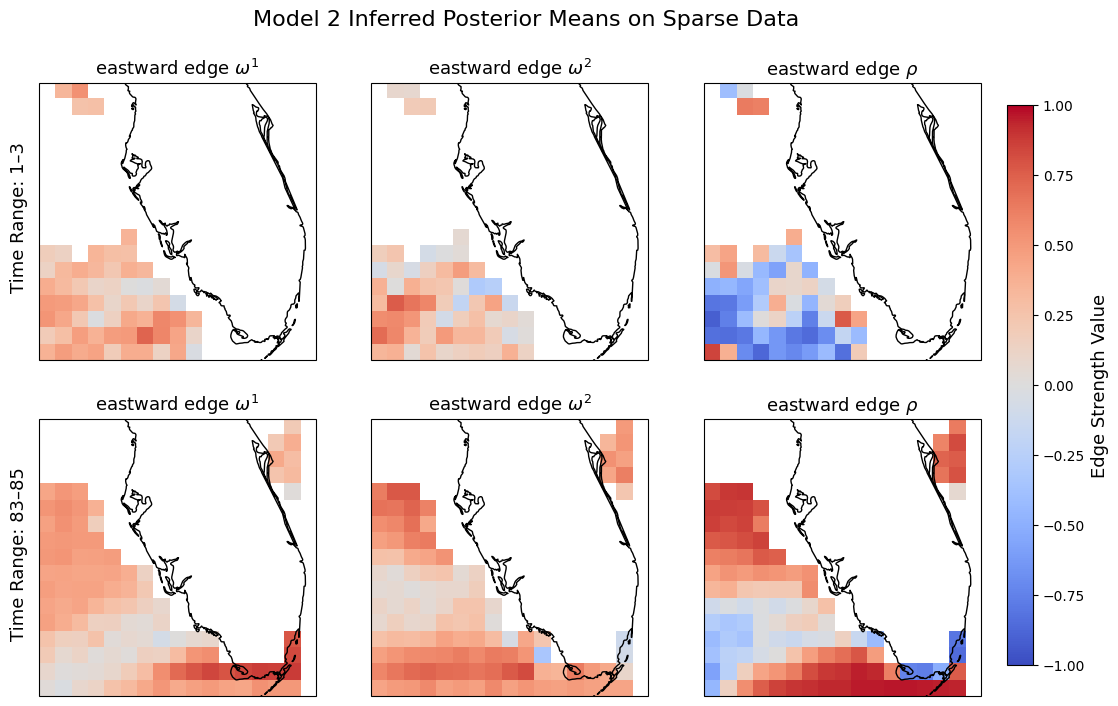

In [148]:
# Run the loop
run_configs = [
    {"model_n": 21, "sparse": 1,  "time_range": (1, 3)},
    {"model_n": 21, "sparse": 1,  "time_range": (83, 85)}
    ]
small_summary_comparison_figure(run_configs[0], run_configs[1])

---

In [ ]:
# Configuration
model_n = 21
sparse = 1
time_steps = (83, 85)

# File path
if sparse:
    summary_filename = f"/Volumes/KINGSTON/M4R_usb/R/modular/nms{model_n}[{time_steps[0]}-{time_steps[1]}]_sparse.csv"
    output_filename = f"/Volumes/KINGSTON/M4R_usb/R/modular/nms{model_n}[{time_steps[0]}-{time_steps[1]}]_sparse_cut.csv"
else:
    summary_filename = f"/Volumes/KINGSTON/M4R_usb/R/modular/nms{model_n}[{time_steps[0]}-{time_steps[1]}].csv"
    output_filename = f"/Volumes/KINGSTON/M4R_usb/R/modular/nms{model_n}[{time_steps[0]}-{time_steps[1]}]_cut.csv"

# Read data
df = pd.read_csv(summary_filename)

# Always include lp__
filtered_df = df[df["variable"] == "lp__"]

# Function to get first 10 from group where rhat < 1.01
def filter_group(prefix):
    return df[df["variable"].str.startswith(prefix)].head(5)

# Append filtered results for each variable group
for prefix in ["w1[", "w2[", "p[", "phi["]:
    filtered_df = pd.concat([filtered_df, filter_group(prefix)], axis=0)

# Reset index and display result
filtered_df = filtered_df.reset_index(drop=True)
filtered_df.to_csv(output_filename, index=False)
print(filtered_df)

---

In [52]:
nm_model = {
    19: "Model 1",
    21: "Model 2",
    22: "Model 3",
    23: "Model 4",
    12: r"Model 1 ($\boldsymbol{\phi}$ removed)",
    17: r"Model 2 ($\boldsymbol{\phi}$ removed)",
    15: r"Model 3 ($\boldsymbol{\phi}$ removed)",
    16: r"Model 4 ($\boldsymbol{\phi}$ removed)",
}
label_sparse = {1: "Filtered", 0: "Unfiltered"}

def plot_correlation_comparison(correlation_name, configs):
    """
    Produce a 1×3 row of heatmaps for a single correlation_name, using three
    different (model_n, sparse, time_range) configs.
    
    - configs: a list of exactly three dicts, each with keys:
        { "model_n": int, "sparse": 0 or 1, "time_range": (start, end) }
    - correlation_name: e.g. "tot_w1[5]" (must match entries in processed_draws)
    """
    assert len(configs) == 3, "Provide exactly three configurations."

    # Create 1×3 figure
    fig, axes = plt.subplots(
        nrows=1, ncols=3, figsize=(15, 5),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )

    # Colorbar will be shared; remember last 'mesh'
    mesh = None

    # Define lat/lon extent once
    extent = [-84.125, -79.875, 24.875, 29.125]

    for ax, cfg in zip(axes.flat, configs):
        model_n = cfg["model_n"]
        sparse   = cfg["sparse"]
        ts0, ts1 = cfg["time_range"]

        # 1) Build the filenames
        if sparse:
            draws_filename = (f"/Volumes/KINGSTON/M4R_usb/R/modular/"
                              f"nm{model_n}[{ts0}-{ts1}]_sparse_draws.csv")
            edge_map_filenames = [
                f"R/notebook_models/[{ts0}-{ts1}]_sparse_edge_map.csv",
                f"R/notebook_models/[{ts0}-{ts1}]_sparse_edge_diag_map.csv"
            ]
        else:
            draws_filename = (f"/Volumes/KINGSTON/M4R_usb/R/modular/"
                              f"nm{model_n}[{ts0}-{ts1}]_draws.csv")
            edge_map_filenames = [
                "R/notebook_models/edge_map.csv",
                "R/notebook_models/edge_diag_map.csv"
            ]

        # 2) Load edge‐maps, build dicts
        edge_map_df      = pd.read_csv(edge_map_filenames[0])
        edge_diag_map_df = pd.read_csv(edge_map_filenames[1])
        edge_map      = dict(zip(edge_map_df["edge_id"],      edge_map_df["edge_key"]))
        edge_diag_map = dict(zip(edge_diag_map_df["edge_id"], edge_diag_map_df["edge_key"]))

        # 3) Read draws, rename columns, process
        draws = pd.read_csv(draws_filename)
        draws.columns = [rename_param(col, edge_map, edge_diag_map)
                         for col in draws.columns]
        processed_draws = process_draws(draws)

        # 4) Compute the mean of the last 100 iterations for 'correlation_name'
        #    over iterations draw-100 … draw. We fix draw=1000 as before.
        draw_idx = 1000
        all_cols = [c for c in processed_draws.columns
                    if c.startswith(correlation_name)]
        # take iterations [draw_idx-100 : draw_idx]
        t1_data = processed_draws.loc[draw_idx-100 : draw_idx, all_cols]
        t2_data = zone_data.copy()
        t2_data[correlation_name] = t1_data.mean(axis=0).values

        # 5) Pivot into a heatmap (lat × lon grid)
        heatmap_data = (
            t2_data
            .pivot(index='latitude_rank',
                   columns='longitude_rank',
                   values=correlation_name)
            .sort_index(ascending=False)
        )

        # 6) Plot
        mesh = ax.imshow(
            heatmap_data,
            extent=extent,
            origin="upper",
            cmap="coolwarm",
            vmin=-1, vmax=1
        )
        ax.add_feature(cfeature.COASTLINE, edgecolor='black')

        # 7) Title each subplot with model/sparse/time info
        title = (f"{nm_model[model_n]} — {label_sparse[sparse]}\n"
                 f"Time Steps {ts0}–{ts1}")
        ax.set_title(title, fontsize=15)

    # 8) Adjust layout and add a single vertical colorbar on the right
    fig.subplots_adjust(right=0.85, wspace=0.1)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(mesh, cax=cbar_ax, orientation='vertical')
    cbar.set_label("Edge Strength Value", fontsize=14)
    cbar.ax.tick_params(labelsize=10)

    # 9) Super‐title for the entire row
    shared_title = (f"Heatmap of '{correlation_labels[correlation_name]}' Posterior Means\n"
                    f"({nm_model[configs[0]['model_n']]}, {configs[0]['time_range'][0]}–{configs[0]['time_range'][1]}) | "
                    f"({nm_model[configs[1]['model_n']]}, {configs[1]['time_range'][0]}–{configs[1]['time_range'][1]}) | "
                    f"({nm_model[configs[2]['model_n']]}, {configs[2]['time_range'][0]}–{configs[2]['time_range'][1]})")
    plt.suptitle(shared_title, fontsize=16, x=0.5, y=1.1)
    # plt.show()
    # 10) Save or show
    #plt.savefig(
    #     f"/Volumes/KINGSTON/M4R_usb/R/modular/summary_figures/"
    #     f"{correlation_name.replace('[','').replace(']','')}_comparison.pdf",
    #     dpi=300, bbox_inches='tight')
    plt.close(fig)

In [53]:
run_configs = [
    {"model_n": 19, "sparse": 0,  "time_range": (1, 3)},
    {"model_n": 19, "sparse": 0,  "time_range": (83, 85)},
    {"model_n": 19, "sparse": 0,  "time_range": (100, 103)}]

plot_correlation_comparison("east_p", run_configs)

In [76]:
def compare_correlation_heatmaps(configs, correlation_names):
    """
    Plots a 2x2 grid of heatmaps comparing two correlation names across two model configurations.

    Args:
        configs: A list of two dictionaries, each with keys 'model_n', 'sparse', and 'time_range'.
        correlation_names: A list of two correlation name strings.
    """
    assert len(configs) == 2 and len(correlation_names) == 2, "Provide exactly two configs and two correlation names."

    extent = [-84.125, -79.875, 24.875, 29.125]
    draw = 1000

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 7), subplot_kw={'projection': ccrs.PlateCarree()})
    mesh = None  # For colorbar

    for col, config in enumerate(configs):
        model_n = config["model_n"]
        sparse = config["sparse"]
        time_steps = config["time_range"]

        # Load draws and maps
        if sparse:
            draws_filename = f"/Volumes/KINGSTON/M4R_usb/R/modular/nm{model_n}[{time_steps[0]}-{time_steps[1]}]_sparse_draws.csv"
            edge_map_filenames = [f"R/notebook_models/[{time_steps[0]}-{time_steps[1]}]_sparse_edge_map.csv",
                                  f"R/notebook_models/[{time_steps[0]}-{time_steps[1]}]_sparse_edge_diag_map.csv"]
        else:
            draws_filename = f"/Volumes/KINGSTON/M4R_usb/R/modular/nm{model_n}[{time_steps[0]}-{time_steps[1]}]_draws.csv"
            edge_map_filenames = ["R/notebook_models/edge_map.csv", "R/notebook_models/edge_diag_map.csv"]

        edge_map_df = pd.read_csv(edge_map_filenames[0])
        edge_diag_map_df = pd.read_csv(edge_map_filenames[1])
        edge_map = dict(zip(edge_map_df["edge_id"], edge_map_df["edge_key"]))
        edge_diag_map = dict(zip(edge_diag_map_df["edge_id"], edge_diag_map_df["edge_key"]))

        draws = pd.read_csv(draws_filename)
        draws.columns = [rename_param(col, edge_map, edge_diag_map) for col in draws.columns]
        processed_draws = process_draws(draws)

        for row, corr_name in enumerate(correlation_names):
            ax = axes[row, col]
            t1_data = processed_draws.loc[draw-500:draw, [c for c in processed_draws.columns if c.startswith(corr_name)]]
            t2_data = zone_data.copy()
            t2_data[corr_name] = list(np.mean(t1_data.loc[draw-100:draw, :], axis=0))

            heatmap_data = t2_data.pivot(index='latitude_rank', columns='longitude_rank', values=corr_name).sort_index(ascending=False)
            mesh = ax.imshow(heatmap_data, extent=extent, origin="upper", cmap="coolwarm", vmin=-1, vmax=1)
            ax.add_feature(cfeature.COASTLINE, edgecolor='black')

            title = correlation_labels.get(corr_name, corr_name)
            model_label = f"{correlation_labels.get(corr_name, corr_name)} ({nm_model[model_n]}, {'Filtered' if sparse else 'Unfiltered'})"
            ax.set_title(model_label, fontsize=10)

    # Adjust layout
    fig.subplots_adjust(right=0.9, hspace=0.3)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(mesh, cax=cbar_ax, orientation='vertical', label="Edge Strength Value")

    plt.suptitle("Model 1 and Model 2 Comparison", fontsize=14, y=0.96)
    plt.savefig(
         f"/Volumes/KINGSTON/M4R_usb/R/modular/summary_figures/"
         f"Model12[83-85]_comparison.pdf",
         dpi=300, bbox_inches='tight')
    plt.show()

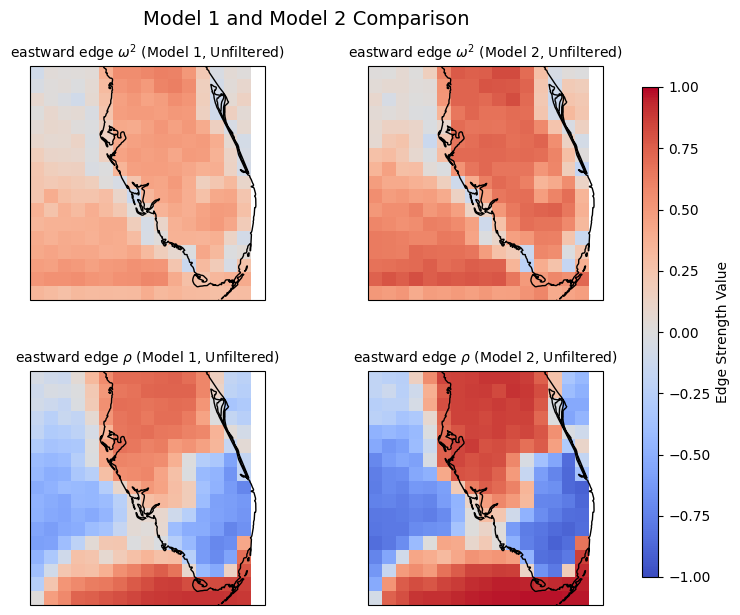

In [77]:
run_configs = [
    {"model_n": 19, "sparse": 0,  "time_range": (83, 85)},
    {"model_n": 21, "sparse": 0,  "time_range": (83, 85)}]
cn = ["east_w2", "east_p"]
compare_correlation_heatmaps(run_configs, cn)